# Compare with Philly trace

In this notebook, we plot a graph for comparing job characteristics between Helios and Philly. 

(a) CDF of the GPU job duration. 
(b) Distribution of GPU time by the final job status.

In [1]:
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc

matplotlib.font_manager._rebuild()

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()


def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=12.5,
        )

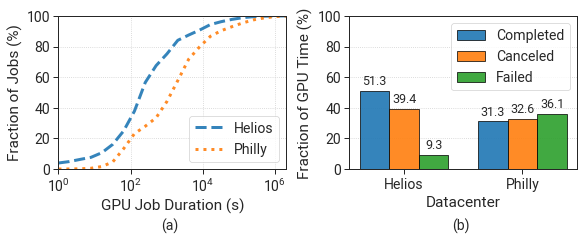

In [2]:
def compare_philly(save=False):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, nrows=1, constrained_layout=True, figsize=(8, 3.2)
    )

    cluster_list = ["Helios", "Philly"]
    linestyles = ["--", ":"]
    df = pd.read_csv(f"./helios_cluster_summary.csv")

    for k in range(0, len(cluster_list)):
        job_ratio, cjob_ratio = [], []
        time = [2 ** i for i in range(0, 22)]
        if cluster_list[k] == "Helios":
            log = pd.read_csv("../../data/all_cluster_log.csv")
        elif cluster_list[k] == "Philly":
            log = pd.read_csv("./philly_trace.csv")

        log = log[log["gpu_num"] > 0]

        for t in time:
            job_ratio.append(len(log[log["duration"] <= t]) / len(log) * 100)

        ax1.plot(time, job_ratio, linestyles[k], alpha=0.9, label=cluster_list[k])

    ax1.set_xlabel(f"GPU Job Duration (s)")
    ax1.set_ylabel(f"Fraction of Jobs (%)")
    ax1.set_xscale("log")
    ax1.set_xlim(1, time[-1])
    ax1.set_ylim(0, 100)
    ax1.legend(loc="lower right")
    ax1.grid(linestyle=":")
    ax1.text(0.45, -0.4, "(a)", transform=ax1.transAxes, size=14)

    philly = pd.read_csv("./philly_trace.csv")

    helios_gpu_time = df.loc[4, "complete_gpu_time":"fail_gpu_time"].sum()
    gpu_time = pd.DataFrame(
        df.loc[4, "complete_gpu_time":"fail_gpu_time"] / helios_gpu_time
    )
    gpu_time.columns = ["Helios"]

    philly_gpu_time = (philly["gpu_num"] * philly["duration"]).sum()
    gcomplete = philly[philly["state"] == "Pass"]
    gcancel = philly[philly["state"] == "Killed"]
    gfailed = philly[philly["state"] == "Failed"]

    gpu_time.at["complete_gpu_time", "Philly"] = (
        gcomplete["gpu_num"] * gcomplete["duration"]
    ).sum() / philly_gpu_time
    gpu_time.at["cancel_gpu_time", "Philly"] = (
        gcancel["gpu_num"] * gcancel["duration"]
    ).sum() / philly_gpu_time
    gpu_time.at["fail_gpu_time", "Philly"] = (
        gfailed["gpu_num"] * gfailed["duration"]
    ).sum() / philly_gpu_time
    gpu_time = gpu_time.T

    x = np.arange(1, 3)
    width = 0.25
    p1 = ax2.bar(
        x - width,
        gpu_time["complete_gpu_time"] * 100,
        width,
        label="Completed",
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
    )
    p2 = ax2.bar(
        x,
        gpu_time["cancel_gpu_time"] * 100,
        width,
        label="Canceled",
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
    )
    p3 = ax2.bar(
        x + width,
        gpu_time["fail_gpu_time"] * 100,
        width,
        label="Failed",
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
    )
    autolabel(p1, ax2)
    autolabel(p2, ax2)
    autolabel(p3, ax2)

    ax2.set_xlabel(f"Datacenter")
    ax2.set_ylabel(f"Fraction of GPU Time (%)")
    ax2.set_xticks(x)
    ax2.set_xticklabels(gpu_time.index)
    ax2.set_ylim(0, 100)
    ax2.grid(axis="y", linestyle=":")
    ax2.legend()
    ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=14)

    if save:
        fig.savefig(
            f"./compare_philly.pdf", bbox_inches="tight", dpi=600,
        )


compare_philly(save=True)